# *Решение kaggle*

## *Необходимые библиотеки*

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer,matthews_corrcoef
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

In [47]:
train = pd.read_csv('train-2.csv', usecols=lambda column: column != 'id')
test = pd.read_csv('test-2.csv', usecols=lambda column: column != 'id')
results = pd.read_csv('sample_submission.csv')

## *Предобработка данных*

In [48]:
train['cap-diameter'] = train['cap-diameter'].clip(lower=0.5, upper=150)
test['cap-diameter'] = test['cap-diameter'].clip(lower=0.5, upper=150)

train['stem-height'] = train['stem-height'].clip(lower=1, upper=50)
test['stem-height'] = test['stem-height'].clip(lower=1, upper=50)

train['stem-width'] = train['stem-width'].clip(lower=0.5, upper=100)
test['stem-width'] = test['stem-width'].clip(lower=0.5, upper=100)

In [49]:
train['does-bruise-or-bleed'] = train['does-bruise-or-bleed'].where(train['does-bruise-or-bleed'].isin(['f', 't']), np.nan)
test['does-bruise-or-bleed'] = test['does-bruise-or-bleed'].where(test['does-bruise-or-bleed'].isin(['f', 't']), np.nan)

train['has-ring'] = train['has-ring'].where(train['has-ring'].isin(['f', 't']), np.nan)
test['has-ring'] = test['has-ring'].where(test['has-ring'].isin(['f', 't']), np.nan)

cols = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment',
            'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 
            'stem-color','veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat']

for col in cols:
    train[col] = train[col].where(train[col].str.match(r'^[a-z]$'), np.nan)
    test[col] = test[col].where(test[col].str.match(r'^[a-z]$'), np.nan)

In [51]:
y_train = train['class']
le = LabelEncoder()
y_train = le.fit_transform(y_train)
train = train.drop('class', axis=1)
y_train

array([0, 1, 0, ..., 1, 0, 1])

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # X should be a DataFrame
        self.frequency_ = {}
        for column in X.columns:
            self.frequency_[column] = X[column].value_counts()
        return self

    def transform(self, X):
        # X should be a DataFrame
        X_transformed = X.copy()
        for column in X.columns:
            # Replace NaNs with -1
            X_transformed[column] = X[column].map(self.frequency_.get(column, {})).fillna(-1)
        return X_transformed

In [53]:
num_cols = train.select_dtypes(include = ['number']).columns
num_imputer = SimpleImputer(strategy ='median')

ordinal_cols = ['has-ring', 'does-bruise-or-bleed']

frequency_cols = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment',
                   'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 
                   'stem-color', 'veil-type', 'veil-color', 'ring-type', 
                   'spore-print-color', 'habitat','season']

ordinal_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    encoded_missing_value=-1
)

scaler = StandardScaler()
frequency_encoder = FrequencyEncoder()

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipeline(steps=[
            ('imputer', num_imputer),
            ('scaler', scaler)
        ]), num_cols),
        ('ordinal_encoder', ordinal_encoder, ordinal_cols),
        ('frequency_encoder', frequency_encoder, frequency_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor)
])

In [54]:
train = pd.DataFrame(pipeline.fit_transform(train), columns=num_cols.tolist() + ordinal_cols + frequency_cols)
test = pd.DataFrame(pipeline.transform(test), columns=num_cols.tolist() + ordinal_cols + frequency_cols)

In [55]:
train['cdsh'] = train['cap-diameter'] * train['stem-height'] 
test['cdsh'] = test['cap-diameter'] * test['stem-height']

### *Знакомство с данными*

In [56]:
train.head()

,cap-diameter,stem-height,stem-width,has-ring,does-bruise-or-bleed,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,ring-type,spore-print-color,habitat,season,cdsh
0,0.534605,-0.681189,0.523285,0.0,0.0,676238.0,384970.0,73172.0,646034.0,1331054.0,...,-1.0,-1.0,1196637.0,-1.0,-1.0,2477170.0,-1.0,2177573.0,1543321.0,-0.364167
1,-0.386406,-0.577444,-0.577355,1.0,0.0,1436026.0,284460.0,178847.0,646034.0,1331054.0,...,-1.0,255500.0,111541.0,-1.0,-1.0,113780.0,-1.0,2177573.0,278189.0,0.223128
2,0.135286,0.185817,-0.151182,0.0,0.0,676238.0,384970.0,61313.0,360878.0,1331054.0,...,-1.0,327610.0,1003464.0,-1.0,-1.0,2477170.0,-1.0,171892.0,278189.0,0.025138
3,-0.521659,-0.810869,-0.571179,0.0,0.0,676238.0,327826.0,210825.0,295439.0,-1.0,...,-1.0,-1.0,1196637.0,-1.0,-1.0,2477170.0,-1.0,2177573.0,1153588.0,0.422997
4,-0.098724,-1.103576,-0.345122,0.0,0.0,1436026.0,44859.0,379442.0,589236.0,-1.0,...,-1.0,-1.0,1196637.0,-1.0,-1.0,2477170.0,-1.0,454908.0,1543321.0,0.108950


In [57]:
test.head()

,cap-diameter,stem-height,stem-width,has-ring,does-bruise-or-bleed,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,ring-type,spore-print-color,habitat,season,cdsh
0,0.500255,1.771621,0.736990,1.0,1.0,1436026.0,-1.0,1359542.0,-1.0,-1.0,...,165801.0,-1.0,1196637.0,159373.0,279070.0,63687.0,-1.0,2177573.0,1543321.0,0.886262
1,0.126698,-1.881657,-0.049888,0.0,0.0,108835.0,460777.0,178847.0,-1.0,1331054.0,...,-1.0,-1.0,1003464.0,-1.0,-1.0,2477170.0,-1.0,2177573.0,1543321.0,-0.238403
2,-0.925273,-0.062428,-0.989941,0.0,0.0,318646.0,263729.0,1359542.0,-1.0,1331054.0,...,-1.0,-1.0,1003464.0,-1.0,-1.0,2477170.0,-1.0,2177573.0,141847.0,0.057763
3,-0.609681,-0.507046,-0.326592,1.0,0.0,1436026.0,460777.0,1359542.0,295439.0,1331054.0,...,-1.0,-1.0,1196637.0,-1.0,30039.0,113780.0,-1.0,2177573.0,1153588.0,0.309137
4,-0.030024,0.141355,0.314522,1.0,0.0,1436026.0,284460.0,386627.0,279110.0,-1.0,...,-1.0,-1.0,373971.0,-1.0,30473.0,-1.0,-1.0,2177573.0,1153588.0,-0.004244


In [58]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116945.0,6.534738e-17,1.000000,-1.247304,-6.418845e-01,-1.201929e-01,4.143799e-01,1.596422e+01
stem-height,3116945.0,9.908656e-16,1.000000,-1.981696,-6.219061e-01,-1.735830e-01,3.933050e-01,1.617354e+01
stem-width,3116945.0,1.713931e-15,1.000000,-1.316057,-7.638837e-01,-1.857695e-01,5.529319e-01,1.097505e+01
has-ring,3116945.0,2.399269e-01,0.427146,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
does-bruise-or-bleed,3116945.0,1.754821e-01,0.380478,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
cap-shape,3116945.0,8.946410e+05,525430.963446,-1.000000,3.651460e+05,6.762380e+05,1.436026e+06,1.436026e+06
cap-surface,3116945.0,2.307137e+05,161347.908009,-1.000000,1.098400e+05,2.637290e+05,3.849700e+05,4.607770e+05
cap-color,3116945.0,7.334065e+05,558919.054929,-1.000000,1.972900e+05,3.866270e+05,1.359542e+06,1.359542e+06
gill-attachment,3116945.0,3.739190e+05,228099.970504,-1.000000,2.791100e+05,3.608780e+05,5.892360e+05,6.460340e+05
gill-spacing,3116945.0,6.263709e+05,621747.190367,-1.000000,-1.000000e+00,4.079320e+05,1.331054e+06,1.331054e+06


In [59]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,2077964.0,-8.322031e-04,1.002152,-1.247304,-6.440314e-01,-1.223398e-01,4.122331e-01,3.084854e+01
stem-height,2077964.0,-6.776451e-04,0.999838,-1.981696,-6.219061e-01,-1.735830e-01,3.933050e-01,1.617354e+01
stem-width,2077964.0,-6.686718e-04,1.000581,-1.316057,-7.638837e-01,-1.870048e-01,5.516966e-01,1.097505e+01
has-ring,2077964.0,2.404498e-01,0.427484,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
does-bruise-or-bleed,2077964.0,1.752446e-01,0.380271,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
cap-shape,2077964.0,8.952969e+05,525124.965341,-1.000000,3.651460e+05,6.762380e+05,1.436026e+06,1.436026e+06
cap-surface,2077964.0,2.307484e+05,161312.793528,-1.000000,1.098400e+05,2.637290e+05,3.849700e+05,4.607770e+05
cap-color,2077964.0,7.324997e+05,558620.473799,-1.000000,1.972900e+05,3.866270e+05,1.359542e+06,1.359542e+06
gill-attachment,2077964.0,3.738891e+05,228161.040513,-1.000000,2.791100e+05,3.608780e+05,5.892360e+05,6.460340e+05
gill-spacing,2077964.0,6.261234e+05,621732.984950,-1.000000,-1.000000e+00,4.079320e+05,1.331054e+06,1.331054e+06


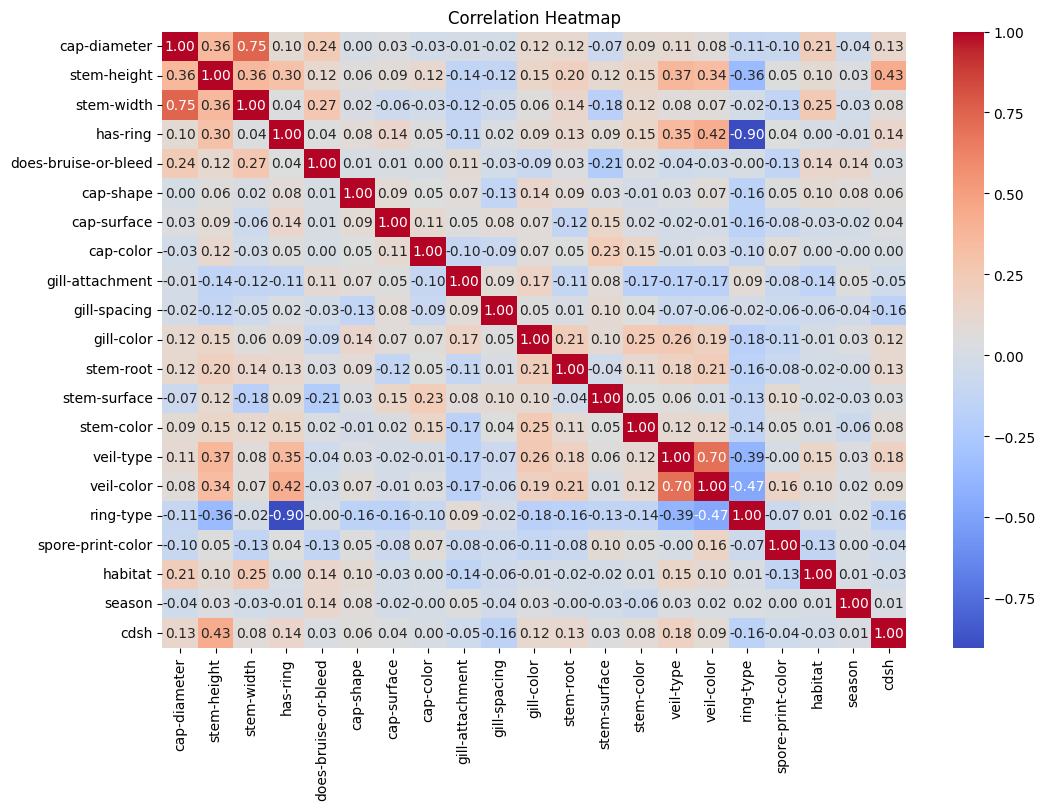

In [60]:
correlation_matrix = train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### *Работа с пропусками*

In [61]:
result = pd.concat([train.isnull().sum(), train.isnull().mean()], axis=1)
result.rename(index=str, columns={0: 'total missing',1: 'proportion'})

,total missing,proportion
cap-diameter,0,0.0
stem-height,0,0.0
stem-width,0,0.0
has-ring,0,0.0
does-bruise-or-bleed,0,0.0
cap-shape,0,0.0
cap-surface,0,0.0
cap-color,0,0.0
gill-attachment,0,0.0
gill-spacing,0,0.0


In [62]:
result = pd.concat([test.isnull().sum(), test.isnull().mean()], axis=1)
result.rename(index=str, columns={0: 'total missing',1: 'proportion'})

,total missing,proportion
cap-diameter,0,0.0
stem-height,0,0.0
stem-width,0,0.0
has-ring,0,0.0
does-bruise-or-bleed,0,0.0
cap-shape,0,0.0
cap-surface,0,0.0
cap-color,0,0.0
gill-attachment,0,0.0
gill-spacing,0,0.0


### *Масштабирование*

In [63]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numerical = [
    col for col in train.select_dtypes(include=["int", "float"]).columns.tolist()
]

print(f"Numerical Columns: {numerical}")

numerical_pipeline = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("imputer", SimpleImputer(strategy="mean"))
])
preprocess = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical)
])

train_processed = preprocess.fit_transform(train)
test_processed = preprocess.fit_transform(test)

# Convert back to DataFrame for readability
train = pd.DataFrame(train_processed, columns=train.columns, index=train.index)
test = pd.DataFrame(test_processed, columns=test.columns, index=test.index)

Numerical Columns: ['cap-diameter', 'stem-height', 'stem-width', 'has-ring', 'does-bruise-or-bleed', 'cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season', 'cdsh']


## *Обучение модели*

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_model.fit(train, y_train)

GradientBoostingClassifier(random_state=42)

In [79]:
test_pred = gb_model.predict(test)
test_pred

array([0, 1, 1, ..., 1, 0, 0])

In [80]:
test_pred_class = le.inverse_transform(test_pred)
test_pred_class

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype=object)

In [81]:
results['class']= test_pred_class

results.to_csv('submission_baseline.csv', index = False)

## *Усиление бейслайна*

### *Генерация признаков*

In [64]:
train['count'] = train.count(axis=1) 
train['sum'] = train.sum(axis=1)      
train['average'] = train.mean(axis=1)
train['median'] = train.median(axis=1)
train['mode'] = train.mode(axis=1)[0]  
train['max'] = train.max(axis=1)    
train['min'] = train.min(axis=1) 

In [65]:
test['count'] = test.count(axis=1) 
test['sum'] = test.sum(axis=1)      
test['average'] = test.mean(axis=1)
test['median'] = test.median(axis=1)
test['mode'] = test.mode(axis=1)[0]  
test['max'] = test.max(axis=1)    
test['min'] = test.min(axis=1) 

In [66]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)

voting_classifier = VotingClassifier(
    estimators=[
        ('gb', gb_model),
        ('rf', rf_model),
        ('knn', knn_model)
    ],
    voting='soft'
)

voting_classifier.fit(train, y_train)

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=150,
                                                         random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=150,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

In [67]:
y_pred = voting_classifier.predict(test)

In [68]:
y_pred_class = le.inverse_transform(y_pred)
y_pred_class

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype=object)

In [69]:
results['class']= y_pred_class

results.to_csv('submission_with_ensemble.csv', index = False)